## DATA 780: Final Project Bagging

Features:
* ID: Unique identifier for each student
* Demographics: Age, Gender, City
* Academic Indicators: CGPA, Academic Pressure, Study Satisfaction
* Lifestyle & Wellbeing: Sleep Duration, Dietary Habits, Work Pressure, Job Satisfaction, Work/Study Hours
* Additional Factors: Profession, Degree, Financial Stress, Family History of Mental Illness, and whether the student has ever had suicidal thoughts


Target Variable:
* Depression_Status: A binary indicator (0/1 or Yes/No) that denotes whether a student is experiencing depression

In [31]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
data = pd.read_csv('student_depression_dataset.csv')

data.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [4]:
# Rename Columns
data = data.rename(columns={'CGPA':'Cumulative GPA'})
data = data.rename(columns={'Have you ever had suicidal thoughts ?' : 'Sucidal thoughts'})
data= data.rename(columns={'Family History of Mental Illness': 'Mental Illness History'})

In [5]:
# Drop columns too granular
data = data.drop(columns=['id', 'City'], errors='ignore')


In [6]:
# Summary of survival by sex
# use pd.crosstab()
contingency = pd.crosstab(data["Depression"], data["Gender"])
print(contingency)

Gender      Female  Male
Depression              
0             5133  6432
1             7221  9115


## Label Encoding

In [7]:
# Encode all categorcal variables
# use LabelEncoder()
cat_col = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in cat_col:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [8]:
# Handle NaNs
data.fillna(data.median(numeric_only=True), inplace=True)


## Split Data into Training and Testing Sets

In [9]:
# Assign Columns to feature and target variables
X = data.drop('Depression', axis = 1).copy() # Features
y = data['Depression'].copy() # Target

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 99)

In [38]:
# Bagging Classifier with Decision Tree estimator
bagging = BaggingClassifier(
    estimator = DecisionTreeClassifier(max_depth=6),
    n_estimators = 100,
    random_state = 99
)

In [39]:
# Fit the Model
bagging.fit(X_train, y_train)

,estimator,DecisionTreeC...r(max_depth=6)
,n_estimators,100
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,99
,verbose,0


In [40]:
# Predict
y_pred = bagging.predict(X_test)

## Bagging Classifier Evaluation

In [44]:
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n",classification_report(y_test, y_pred))

Accuracy:  0.8387385773158932
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.80      2269
           1       0.85      0.88      0.87      3312

    accuracy                           0.84      5581
   macro avg       0.83      0.83      0.83      5581
weighted avg       0.84      0.84      0.84      5581



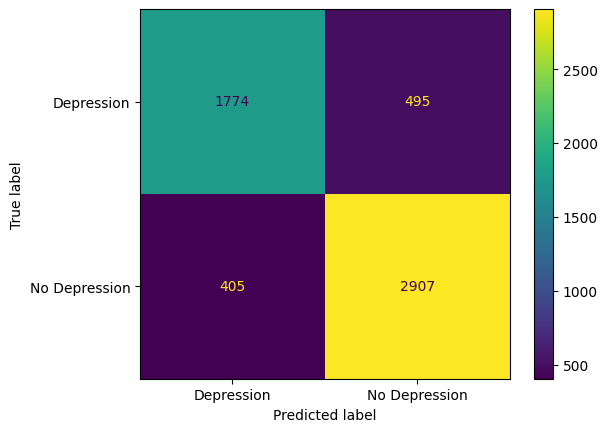

In [45]:
#checking how well it actually preforms on the test dataset
ConfusionMatrixDisplay.from_estimator(bagging,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Depression","No Depression"])

## Feature Importance

In [46]:
feature_importances = np.mean(
    [tree.feature_importances_ for tree in bagging.estimators_],
    axis=0
)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print("\nTop 10 Important Features:\n", importance_df.head(10))


Top 10 Important Features:
                Feature  Importance
11    Sucidal thoughts    0.571523
3    Academic Pressure    0.233157
13    Financial Stress    0.096332
1                  Age    0.045822
12    Work/Study Hours    0.022425
9       Dietary Habits    0.017549
6   Study Satisfaction    0.006825
5       Cumulative GPA    0.003218
10              Degree    0.001546
8       Sleep Duration    0.000608
